In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,-11.276992,level_321,level_185,level_72,level_174,level_291,level_454,level_344,level_39,level_240,...,level_370,level_171,level_262,level_440,level_52,level_20,level_209,level_221,level_496,level_88
1,25.145249,level_71,level_353,level_314,level_92,level_330,level_113,level_167,level_320,level_12,...,level_278,level_28,level_18,level_450,level_302,level_170,level_491,level_382,level_387,level_95
2,-5.311627,level_406,level_426,level_408,level_149,level_24,level_208,level_485,level_66,level_88,...,level_9,level_322,level_256,level_434,level_80,level_217,level_153,level_494,level_124,level_403
3,-14.487789,level_26,level_411,level_79,level_53,level_427,level_159,level_39,level_161,level_136,...,level_21,level_390,level_178,level_393,level_130,level_474,level_457,level_352,level_413,level_180
4,-7.772126,level_295,level_458,level_99,level_61,level_133,level_349,level_43,level_27,level_44,...,level_452,level_262,level_0,level_233,level_234,level_402,level_330,level_334,level_403,level_389


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,5.988383,3.435312,6.887784,-8.321471,-3.280983,0.171248,-8.688407,-1.229704,-5.631637,-10.246187,...,-18.522516,-0.124703,-6.059491,-14.164045,-15.519958,-12.898479,-2.082360,-0.169503,-0.585372,-5.495609
1,-6.260960,1.247718,1.346685,2.256458,6.430721,-18.181880,-6.596203,14.020095,2.626434,-11.676350,...,1.378708,2.158131,7.209188,6.136198,5.029480,8.041606,5.293322,14.161583,9.993550,3.327810
2,-8.657898,5.722156,-1.668257,6.417267,-7.547598,5.348190,-2.161833,-1.397461,-7.773820,-9.217516,...,9.668495,11.709286,1.005397,3.374671,-3.335738,6.986141,-18.284519,2.409772,1.254860,8.665363
3,6.788260,22.536649,6.073600,2.256458,11.321253,16.556994,31.821377,-0.106367,12.313756,8.776970,...,5.295668,17.033450,4.164566,0.822211,0.239367,0.715828,2.690016,2.735490,7.482807,18.806509
4,16.273983,-1.592929,0.509212,8.140388,17.350159,-2.692633,-1.533511,10.643817,-0.145635,2.992333,...,-1.411014,-8.481431,3.030675,9.827377,11.319724,2.865860,15.878105,12.891635,6.836858,5.290730


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,3.736560,2.420465,5.764123,-4.301626,-2.632661,0.144333,-6.763332,-0.812794,-5.144524,-8.159474,...,-9.267358,-0.086630,-2.552012,-9.507605,-13.138327,0.000000,-0.704191,-0.098533,-0.347301,-3.252254
1,-4.828826,0.908031,1.233269,1.590853,5.303366,-2.290292,-5.117143,9.120684,1.541027,-9.621373,...,0.855238,1.552985,4.351391,4.332358,1.915931,6.324388,2.600155,9.182140,7.936512,3.076555
2,-7.246424,3.865343,-1.001872,5.124656,-6.671499,3.410919,-1.824918,-0.632001,-5.970327,-7.878819,...,4.185594,6.675485,0.691919,0.864725,-2.037431,3.235391,-6.477627,2.021106,0.587019,4.711452
3,5.886801,16.847892,3.793032,1.590853,7.935267,5.689800,31.330985,-0.058745,7.521059,4.255494,...,2.335702,11.914874,1.715769,0.532308,0.129870,0.345894,0.350895,1.939706,3.468527,8.362137
4,12.301792,-0.923512,0.270462,4.969504,7.269654,-1.665740,-1.121124,8.880632,-0.093749,1.140897,...,-0.714666,-2.678421,2.269748,3.420342,7.114457,2.426104,11.870866,7.410936,3.047175,3.532776


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,6.203437,4.659843e+00,7.241520,-2.558479,-1.713517,1.996675,-5.812415,0.230236,-3.111562,-6.872277,...,-5.674787,2.220446e-16,-4.543049e+00,-6.232437,0.000000,0.000000e+00,5.393842,1.466741,0.652479,-3.813846
1,-7.746281,3.464060e+00,-1.698147,-1.442922,5.696315,0.000000,-7.076665,14.473233,1.405681,-11.449948,...,0.674388,-7.186170e-01,3.794751e+00,2.251974,1.098739,2.220446e-16,2.604978,5.390464,6.885709,0.662332
2,-2.843194,5.143277e+00,0.000000,5.378120,-6.755832,4.128731,-0.557044,0.093507,-8.239898,-6.921882,...,17.389344,1.375484e+01,2.078493e+00,-3.318136,-0.879336,4.749605e+00,-6.073352,5.700086,2.459657,7.311545
3,4.489097,0.000000e+00,2.367047,-1.442922,8.214811,0.000000,0.000000,-7.327473,0.000000,0.432374,...,-0.301110,1.131523e+01,-4.460914e+00,-2.963576,-0.909165,-6.050595e+00,0.000000,3.027640,0.665204,24.006687
4,0.000000,2.220446e-16,0.803313,3.165742,3.566826,-3.145684,-2.546404,4.305055,-4.355412,-0.588523,...,-3.521333,-1.965593e+01,2.220446e-16,1.271363,6.036308,1.136276e+00,9.935507,5.712929,0.000000,0.330455


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.539749,0.513269,0.182594,0.185823,False
1,var_1_impact_code,0.536902,0.511200,0.154788,0.168166,False
2,var_2_impact_code,0.540248,0.513913,0.171770,0.160203,False
3,var_3_impact_code,0.512245,0.481522,0.106981,0.188406,False
4,var_4_impact_code,0.504565,0.471847,0.099437,0.150709,False
5,var_5_impact_code,0.537337,0.503984,0.152186,0.167080,False
6,var_6_impact_code,0.535683,0.508221,0.151191,0.141894,False
7,var_7_impact_code,0.525014,0.496600,0.153377,0.158186,False
8,var_8_impact_code,0.542097,0.508065,0.185548,0.196579,False
9,var_9_impact_code,0.532288,0.504783,0.170308,0.201383,False


(0.827172319939845, 8.551349694817401e-29)


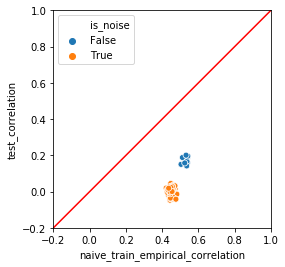

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8243554642254249, 1.8899377910755936e-28)


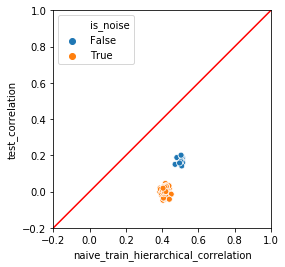

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8114292713414818, 6.049406157459879e-27)


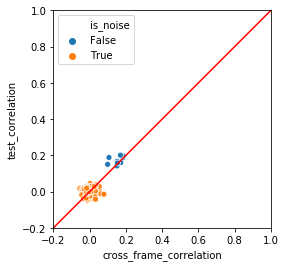

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,impact_code,True,True,-0.015860,0.432464,110.0,False
106,noise_96_impact_code,impact_code,True,True,0.008039,0.690719,110.0,False
107,noise_97_impact_code,impact_code,True,True,-0.014602,0.469846,110.0,False
108,noise_98_impact_code,impact_code,True,True,-0.003559,0.860170,110.0,False
109,noise_99_impact_code,impact_code,True,True,-0.016285,0.420213,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_37_impact_code',
 'noise_49_impact_code',
 'noise_78_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-11.276992,-7.658510,-9.585406,-3.423768,-6.282511
1,25.145249,-18.158748,-16.434306,-5.355212,-7.549956
2,-5.311627,-12.143931,-11.421729,-4.017382,-6.920431
3,-7.772126,6.932968,5.505597,3.687381,7.896584
4,0.412419,-2.101392,-1.127465,-2.577691,-2.890636


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.203786718813218


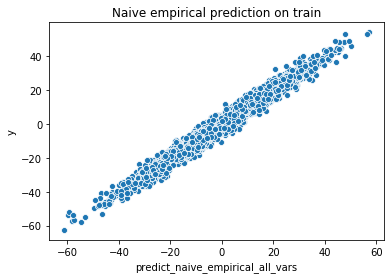

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.802940819394191


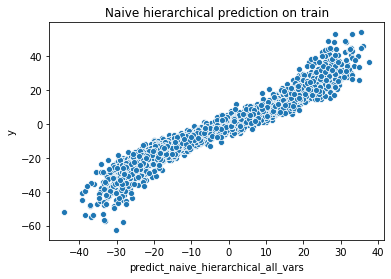

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.520681843826734


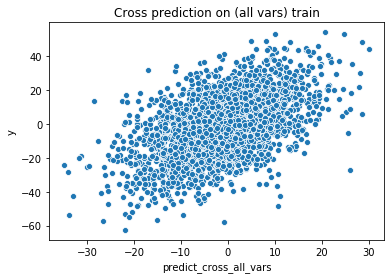

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.853874871351591


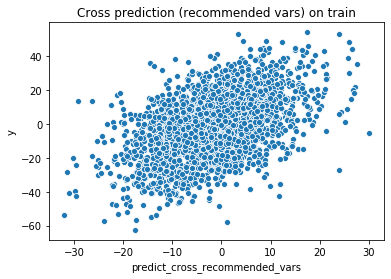

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.919993496982137


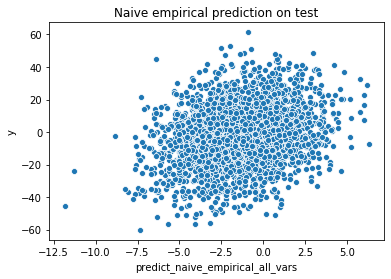

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.571643463710448


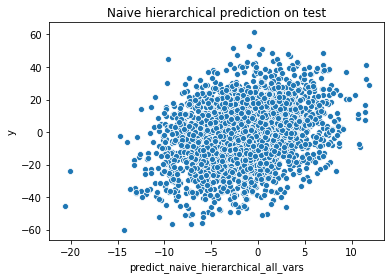

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

16.115291582391944


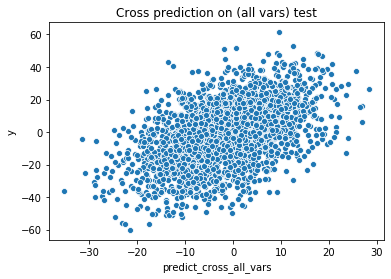

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.77989999944297


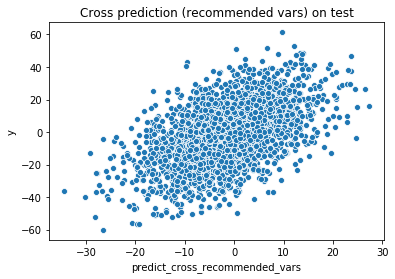

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     670.2
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:54:02   Log-Likelihood:                -6334.2
No. Observations:                2452   AIC:                         1.289e+04
Df Residuals:                    2341   BIC:                         1.353e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.5893      0.066    -24.002      0.000      -1.719      -1.459
var_0_impact_code        0.0696      0.008      8.577      0.000       0.054       0.086
var_1_impact_code        0.0535      0.008      6.546      0.000       0.037       0.069
var_2_impact_code        0.0550      0.008      6.783      0.000       0.039       0.071
var_3_impact_code        0.0640      0.008      7.610      0.000       0.048       0.081
var_4_impact_code        0.0564      0.008      6.669      0.000       0.040       0.073
var_5_impact_code        0.0621      0.008      7.592      0.000       0.046       0.078
var_6_impact_code        0.0599      0.008      7.340      0.000       0.044       0.076
var_7_impact_code        0.0710      0.008      8.618      0.000       0.055       0.087
var_8_impact_code        0.0509      0.008      6.275      0.000       0.035       0.067
var_9_impact_code        0.0665      0.008      8.191      0.000       0.051       0.082
noise_0_impact_code      0.0293      0.009      3.221      0.001       0.011       0.047
noise_1_impact_code      0.0270      0.009      2.892      0.004       0.009       0.045
noise_2_impact_code      0.0341      0.009      3.794      0.000       0.016       0.052
noise_3_impact_code      0.0348      0.009      3.919      0.000       0.017       0.052
noise_4_impact_code      0.0600      0.009      6.586      0.000       0.042       0.078
noise_5_impact_code      0.0410      0.009      4.443      0.000       0.023       0.059
noise_6_impact_code      0.0333      0.009      3.545      0.000       0.015       0.052
noise_7_impact_code      0.0532      0.009      5.794      0.000       0.035       0.071
noise_8_impact_code      0.0512      0.009      5.594      0.000       0.033       0.069
noise_9_impact_code      0.0307      0.009      3.280      0.001       0.012       0.049
noise_10_impact_code     0.0466      0.010      4.830      0.000       0.028       0.066
noise_11_impact_code     0.0268      0.009      2.898      0.004       0.009       0.045
noise_12_impact_code     0.0451      0.009      4.791      0.000       0.027       0.064
noise_13_impact_code     0.0394      0.009      4.354      0.000       0.022       0.057
noise_14_impact_code     0.0460      0.009      5.063      0.000       0.028       0.064
noise_15_impact_code     0.0361      0.009      4.051      0.000       0.019       0.054
noise_16_impact_code     0.0511      0.009      5.505      0.000       0.033       0.069
noise_17_impact_code     0.0427      0.009      4.666      0.000       0.025       0.061
noise_18_impact_code     0.0483      0.009      5.309      0.000       0.030       0.066
noise_19_impact_code     0.0548      0.009      6.102      0.000       0.037       0.072
noise_20_impact_code     0.0456      0.009      4.960    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9692237730974187

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.05472118698417083

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     8.183
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          3.17e-101
Time:                        16:54:03   Log-Likelihood:                -10203.
No. Observations:                2452   AIC:                         2.063e+04
Df Residuals:                    2341   BIC:                         2.127e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.9391      0.327     -5.929      0.000      -2.580      -1.298
var_0_impact_code        0.4535      0.046      9.884      0.000       0.364       0.543
var_1_impact_code        0.3978      0.049      8.116      0.000       0.302       0.494
var_2_impact_code        0.4570      0.048      9.580      0.000       0.363       0.551
var_3_impact_code        0.3153      0.052      6.098      0.000       0.214       0.417
var_4_impact_code        0.3150      0.051      6.151      0.000       0.215       0.415
var_5_impact_code        0.4372      0.049      9.001      0.000       0.342       0.532
var_6_impact_code        0.4048      0.048      8.409      0.000       0.310       0.499
var_7_impact_code        0.3784      0.049      7.749      0.000       0.283       0.474
var_8_impact_code        0.4592      0.048      9.494      0.000       0.364       0.554
var_9_impact_code        0.4054      0.048      8.380      0.000       0.311       0.500
noise_0_impact_code      0.0978      0.060      1.640      0.101      -0.019       0.215
noise_1_impact_code     -0.0280      0.058     -0.480      0.631      -0.142       0.086
noise_2_impact_code      0.0374      0.057      0.657      0.511      -0.074       0.149
noise_3_impact_code      0.0470      0.056      0.842      0.400      -0.062       0.156
noise_4_impact_code      0.0207      0.059      0.348      0.728      -0.096       0.137
noise_5_impact_code     -0.0233      0.058     -0.404      0.686      -0.136       0.090
noise_6_impact_code     -0.0350      0.061     -0.577      0.564      -0.154       0.084
noise_7_impact_code      0.0739      0.059      1.255      0.210      -0.042       0.189
noise_8_impact_code      0.0085      0.059      0.145      0.885      -0.107       0.124
noise_9_impact_code     -0.0732      0.063     -1.166      0.244      -0.196       0.050
noise_10_impact_code    -0.1417      0.063     -2.245      0.025      -0.266      -0.018
noise_11_impact_code    -0.0358      0.060     -0.594      0.553      -0.154       0.082
noise_12_impact_code    -0.0624      0.060     -1.036      0.300      -0.181       0.056
noise_13_impact_code    -0.0199      0.055     -0.360      0.719      -0.128       0.088
noise_14_impact_code    -0.0177      0.062     -0.284      0.777      -0.140       0.105
noise_15_impact_code     0.1181      0.055      2.134      0.033       0.010       0.227
noise_16_impact_code    -0.1126      0.059     -1.905      0.057      -0.229       0.003
noise_17_impact_code    -0.0439      0.059     -0.741      0.458      -0.160       0.072
noise_18_impact_code    -0.0220      0.057     -0.386      0.699      -0.134       0.090
noise_19_impact_code     0.1539      0.056      2.740      0.006       0.044       0.264
noise_20_impact_code     0.0133      0.059      0.223    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.2777130392222006

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.23552979394587548

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     61.31
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          2.73e-139
Time:                        16:54:03   Log-Likelihood:                -10255.
No. Observations:                2452   AIC:                         2.054e+04
Df Residuals:                    2438   BIC:                         2.062e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.7977      0.322     -5.585      0.000      -2.429      -1.167
var_0_impact_code        0.4575      0.045     10.160      0.000       0.369       0.546
var_1_impact_code        0.4058      0.048      8.442      0.000       0.312       0.500
var_2_impact_code        0.4622      0.047      9.845      0.000       0.370       0.554
var_3_impact_code        0.3224      0.051      6.360      0.000       0.223       0.422
var_4_impact_code        0.3284      0.051      6.500      0.000       0.229       0.427
var_5_impact_code        0.4453      0.048      9.315      0.000       0.352       0.539
var_6_impact_code        0.4137      0.047      8.758      0.000       0.321       0.506
var_7_impact_code        0.3735      0.048      7.842      0.000       0.280       0.467
var_8_impact_code        0.4722      0.048      9.934      0.000       0.379       0.565
var_9_impact_code        0.4096      0.048      8.605      0.000       0.316       0.503
noise_37_impact_code     0.0869      0.056      1.545      0.122      -0.023       0.197
noise_49_impact_code     0.1372      0.055      2.482      0.013       0.029       0.246
noise_78_impact_code     0.2217      0.056      3.956      0.000       0.112       0.332
==============================================================================
Omnibus:                        1.918   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                1.919
Skew:                          -0.040   Prob(JB):                        0.383
Kurtosis:                       2.888   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.24636851479120603

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.26701899217761005